<a href="https://colab.research.google.com/github/ermeson-alves/BootcampAvanti-Equipe-2/blob/main/Classifica%C3%A7%C3%A3o_Resultados_preliminares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Tratamento de arquivos
import os
from pathlib import Path

# PDI, processamento e plotagem
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
%matplotlib inline

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision.datasets import ImageFolder

# Tenta otimizar alocação de memória
cudnn.benchmark = True
# Modo interativo do matplotlib
plt.ion()


os.chdir('./')

DATASET_PATH = Path('./data/New Plant Diseases Dataset(Augmented)')
TRAIN_DIR = DATASET_PATH / 'train'
VALID_DIR = DATASET_PATH / 'valid'

# EDA

In [22]:
from pprint import pprint

pprint(sorted([path.name for path in TRAIN_DIR.iterdir()]))

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [23]:
'''Esse codigo é da solução ResNet 99.2%. Utilizado para exibir as Plantas e as
doenças presentes no dataset.'''

plants = []
NumberOfDiseases = 0
for folder in TRAIN_DIR.iterdir():
    # se o nome da planta ainda não está em plants ele é adicionado
    if folder.name.split('___')[0] not in plants:
        plants.append(folder.name.split('___')[0])
    # se não é saudável, mais uma doença é contabilizada
    if folder.name.split('___')[1] != 'healthy':
        NumberOfDiseases += 1


print("Plantas: ")
pprint(sorted(plants))
print(f"Quantidade de plantas: {len(plants)}")

print(f"Número de doenças: {NumberOfDiseases}")

Plantas: 
['Apple',
 'Blueberry',
 'Cherry_(including_sour)',
 'Corn_(maize)',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato']
Quantidade de plantas: 14
Número de doenças: 26


Text(0.5, 1.0, 'Images per each class of plant disease')

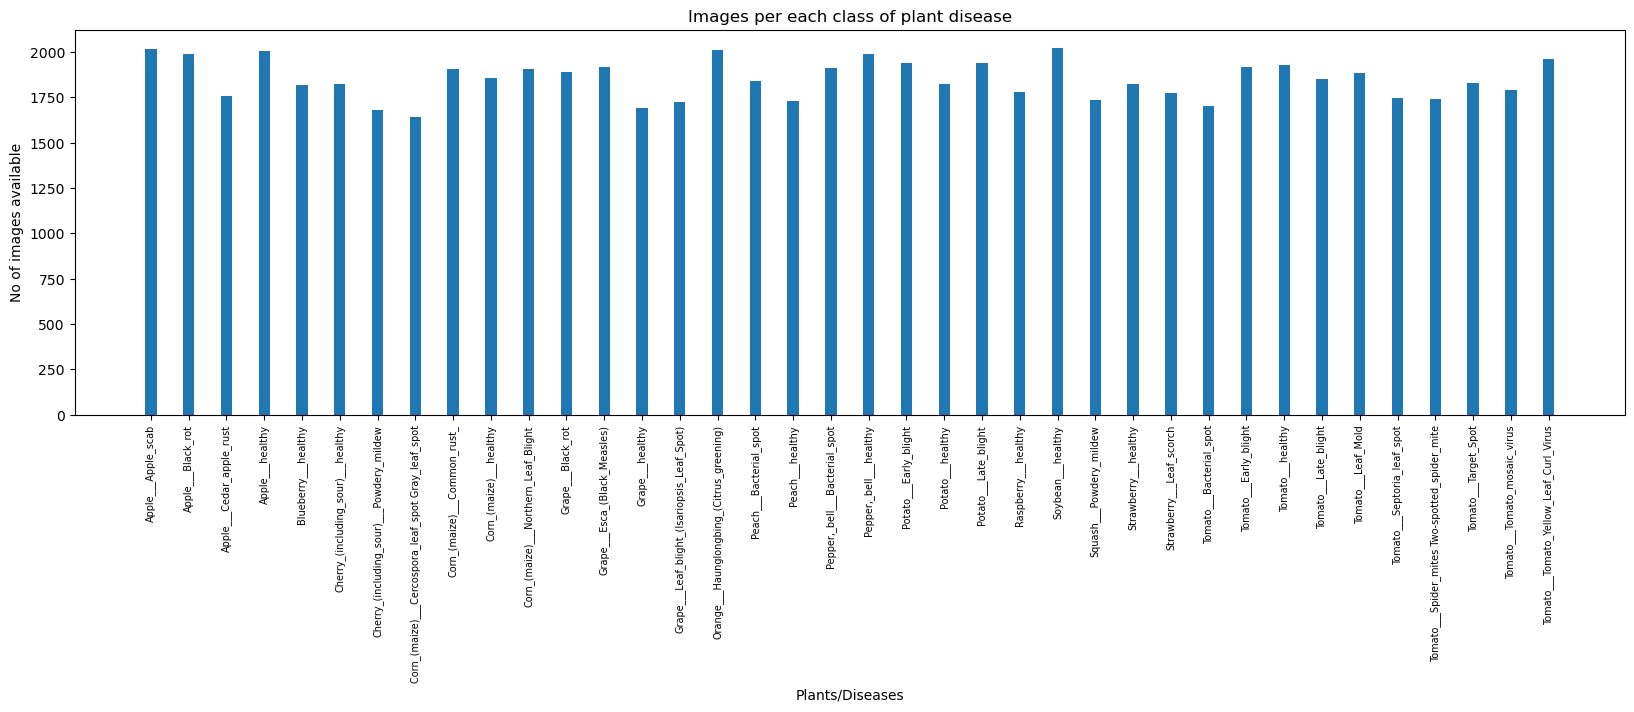

In [24]:
# Quantidade de imagens por cada pasta do conjunto de treino

nums = {}
for folder in TRAIN_DIR.iterdir():
  nums[folder.name] = len(list(folder.iterdir()))

index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, [p.name for p in TRAIN_DIR.iterdir()], fontsize=7, rotation=90)
plt.title('Images per each class of plant disease')

In [25]:
''' Esse código usa classe ImageFolder para criar um obeto carregador dos dados,
baseado em diretorios com o seguinte padrão:

root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png


Os formatos suportados são: (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"),
pelo código fonte. Nossos dados são .jpg.


Fonte: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

'''
# datasets
train = ImageFolder(TRAIN_DIR, transform=transforms.ToTensor())
valid = ImageFolder(VALID_DIR, transform=transforms.ToTensor())

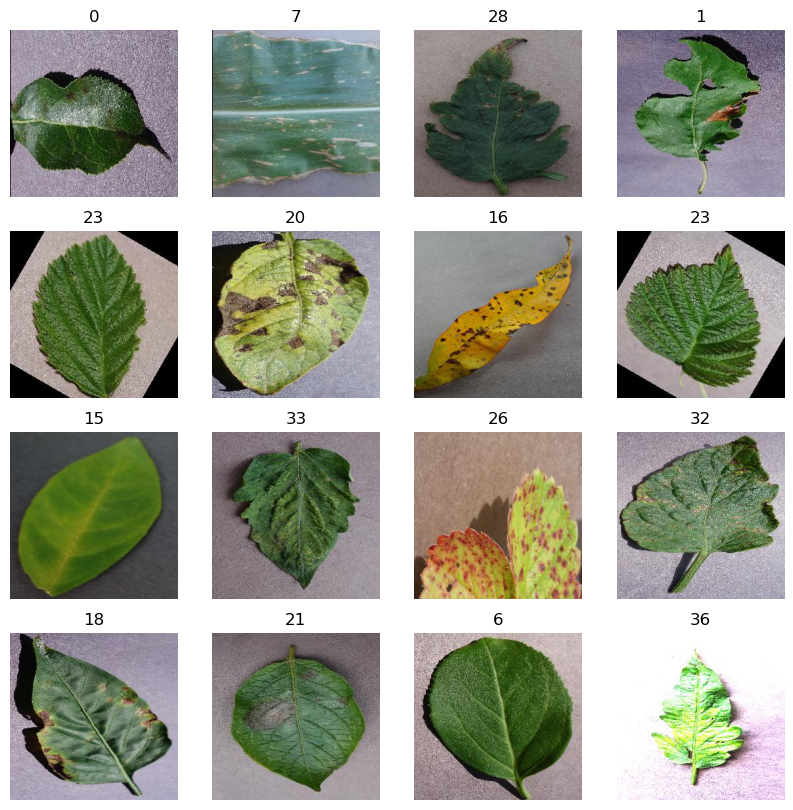

In [26]:
# Exibição:
def show_batch_dataloader(dataloader):
  '''Essa função server para exibir um lote de imagens de um objeto dataloader'''
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break


fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for lin in axs:
  for col in lin:
    idx = random.randint(0, len(train))
    img, label = train[idx]
    col.imshow(img.permute(1,2,0)); col.axis('off'); col.set_title(label)
plt.show()

# Transfer learning + fine tuning

In [56]:
'''Configurações e hiperparâmetros'''
random_seed = 2
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoints_dir = './checkpoints'

batch_size = 32
epochs = 4
criterion = nn.CrossEntropyLoss()

In [136]:
# tamanho dos datasets
dataset_sizes = {'train': len(train),
                 'valid': len(valid)}

# dataloaders
dataloaders = {'train': DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True),
               'valid': DataLoader(valid, batch_size, shuffle=True, num_workers=2, pin_memory=True)}


class_names = train.classes

In [57]:
'''Baseado no tutorial TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL
(https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) criamos
uma função genérica para treinar os modelos:'''


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    since = time.time()

    # Especifica o caminho no qual o modelo será salvo, pós treino
    best_model_params_path = os.path.join(checkpoints_dir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Dependendo se o modelo está sendo treinado ou testado, a função trata ele
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                
                
                # Envia os dados para o dispositivos de processamento (GPU do Colab)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Seleção do valor de "maior probabilidade"
                    _, preds = torch.max(outputs, 1)
                    # Calculo da perda
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    # calculo do tempo de processamento
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model

In [58]:
'''O Pytorch fornece o repositório torch.hub, de onde é possível extrair modelos
pre-treinados em conjuntos de dados massivos e generalistas.
A biblioteca torchvision possui uma api com algumas familias de redes para serem carregadas.

Usaremos RestNet50 e MobileNet-v2
Fonte: https://pytorch.org/docs/stable/hub.html#module-torch.hub;/
https://pytorch.org/vision/stable/models.html#
'''

# Teste atual: ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features

# aqui setamos o size para a saida com base no numero de classes
model.fc = nn.Linear(num_ftrs, len(train.classes))
# enviamos o modelo para a GPU, se disponivel
model = model.to(device)

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Treino:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs=epochs)

## Avaliando

In [ ]:
# Carrega o modelo baseado no arquito .pt
model_trained  = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model_trained.fc = nn.Linear(num_ftrs, len(train.classes))

model_trained.load_state_dict(torch.load('checkpoints/best_model_params.pt'))
model_trained.to(device)

In [107]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
   # mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
   # inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [140]:
def visualize_model(model, num_images=6):
    # was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}', fontsize=8)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return
        model.train(mode=was_training)


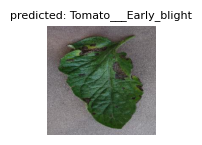

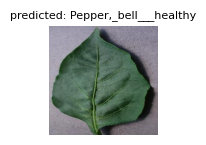

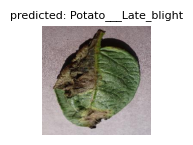

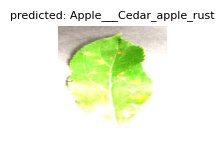

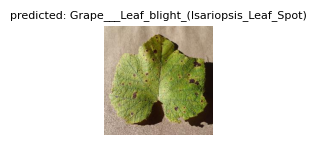

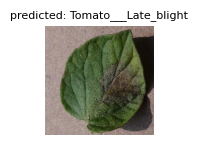

In [148]:
# Executar aqui mais vezes mostra diferentes d
visualize_model(model_trained)